In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('/content/POWER GENERATION DS.csv')

# Filter data for Punjab station
punjab_data = df[df['Power Station'] == 'Punjab']

# Keep the 'Date' column separately for later use
dates = punjab_data['Dates']

# Drop unnecessary columns
punjab_data = punjab_data.drop(['Power Station', 'Dates'], axis=1)

# Replace zeros with NaN, then replace NaNs with column mean
punjab_data = punjab_data.replace(0, np.nan)
punjab_data = punjab_data.fillna(punjab_data.mean())

# Concatenate the 'Date' column back to the cleaned data
punjab_data['Dates'] = dates


punjab_data['Dates'] = pd.to_datetime(punjab_data['Dates']).dt.strftime('%Y-%m-%d')
punjab_data['Dates'] = pd.to_datetime(punjab_data['Dates'])  # Reconvert to datetime
punjab_data.set_index('Dates', inplace=True)

In [ ]:
punjab_data

,Monitored Cap.(MW),Total Cap. Under Maintenace (MW),Planned Maintanence (MW),Forced Maintanence(MW),Other Reasons (MW),Programme or Expected(MU),Actual(MU),Excess(+) / Shortfall (-),Deviation
Dates,,,,,,,,,
2017-09-01,3826.3,2697.65,77.65,2620.000000,128.0,39.00000,17.0,-21.69,34.607959
2017-09-02,3826.3,2697.65,77.65,2620.000000,128.0,39.00000,13.0,-25.60,34.607959
2017-09-03,3826.3,48.40,48.40,1372.286296,128.0,39.00000,13.0,-25.54,34.607959
2017-09-04,3826.3,48.40,48.40,1372.286296,128.0,39.00000,14.0,-24.57,34.607959
2017-09-05,3826.3,48.40,48.40,1372.286296,128.0,39.00000,14.0,-24.07,34.607959
...,...,...,...,...,...,...,...,...,...
2022-04-09,2701.0,360.00,360.00,1372.286296,128.0,27.49787,37.0,15.68,34.607959
2022-04-10,2701.0,360.00,360.00,1372.286296,128.0,27.49787,38.0,16.52,34.607959
2022-04-11,2701.0,360.00,360.00,1372.286296,128.0,27.49787,41.0,19.45,34.607959


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np


# Define the target variable and features
target_column = 'Actual(MU)'
feature_columns = [col for col in punjab_data.columns if col != target_column and col != 'Dates']

# Initialize separate scalers for features and the target
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

# Scale features
features_scaled = scaler_features.fit_transform(punjab_data[feature_columns])

# Scale target
target_scaled = scaler_target.fit_transform(punjab_data[[target_column]])

# Combine scaled features and target into a single dataset
scaled_data = np.hstack((features_scaled, target_scaled))

In [ ]:
import pandas as pd

# Convert features_scaled back to a DataFrame for info()
features_scaled_df = pd.DataFrame(features_scaled, columns=feature_columns, index=punjab_data.index)

# Now you can call info() on the DataFrame
features_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1934 entries, 2017-09-01 to 2022-04-13
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Monitored Cap.(MW)                1934 non-null   float64
 1   Total Cap. Under Maintenace (MW)  1934 non-null   float64
 2   Planned Maintanence (MW)          1934 non-null   float64
 3   Forced Maintanence(MW)            1934 non-null   float64
 4   Other Reasons (MW)                1934 non-null   float64
 5   Programme or Expected(MU)         1934 non-null   float64
 6   Excess(+) / Shortfall (-)         1934 non-null   float64
 7   Deviation                         1934 non-null   float64
dtypes: float64(8)
memory usage: 136.0 KB


In [ ]:
# Create a dataset function for LSTM with multiple features
def create_dataset_multi_feature(data, time_step=1):
    X, y = [], []
    num_features = data.shape[1] - 1  # Last column is the target
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :-1])  # Select all columns except target
        y.append(data[i + time_step, -1])  # Select only the target column
    return np.array(X), np.array(y)

# Create the dataset
time_step = 30
X, y = create_dataset_multi_feature(scaled_data, time_step)

# Reshape X for LSTM input
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=60, validation_data=(X_test, y_test), batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - loss: 0.0656 - val_loss: 0.0216
Epoch 2/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0241 - val_loss: 0.0193
Epoch 3/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0238 - val_loss: 0.0182
Epoch 4/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0207 - val_loss: 0.0167
Epoch 5/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0180 - val_loss: 0.0173
Epoch 6/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0164 - val_loss: 0.0155
Epoch 7/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0179 - val_loss: 0.0157
Epoch 8/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0166 - val_loss: 0.0145
Epoch 9/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 10/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0137 - val_loss: 0.0143
Epoch 11/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0125 - val_loss: 0.0138
Epoch 12/60
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Mean Squared Error (MSE): 56.81444280140137
Root Mean Squared Error (RMSE): 7.537535592048728
R² Score: 0.6599168578781798


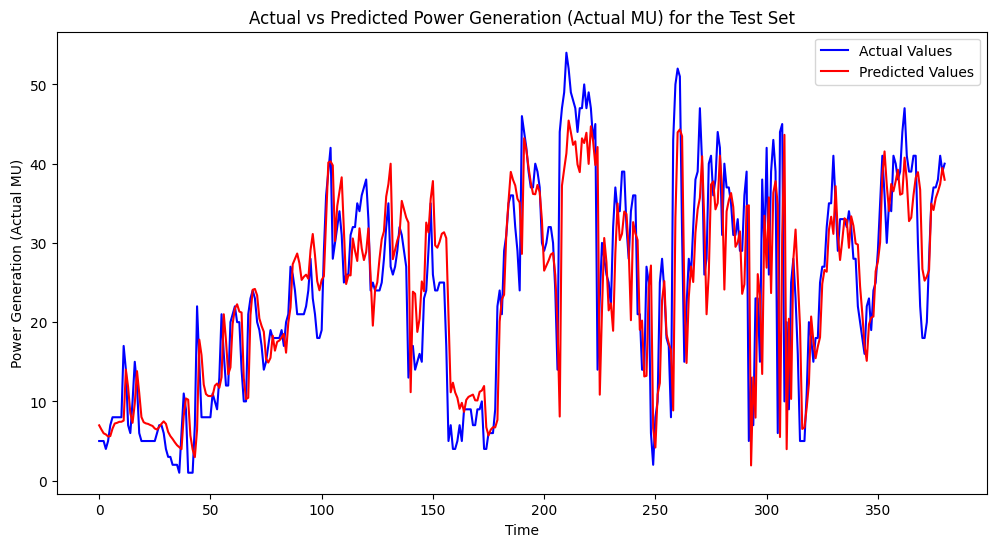

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Predict on the test set using the trained model
y_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and the actual values
y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred)

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')

# Plot the actual vs predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, color='blue', label='Actual Values')
plt.plot(y_pred, color='red', label='Predicted Values')
plt.title('Actual vs Predicted Power Generation (Actual MU) for the Test Set')
plt.xlabel('Time')
plt.ylabel('Power Generation (Actual MU)')
plt.legend()
plt.show()


In [ ]:
forecast_steps = 30
forecast_values = []

# Get the last 'time_step' sequence from the test set
last_data = X_test[-1].reshape(1, time_step, X.shape[2])

for _ in range(forecast_steps):
    # Predict next value
    next_prediction_scaled = model.predict(last_data)

    # Inverse transform only the target using `scaler_target`
    next_prediction = scaler_target.inverse_transform(next_prediction_scaled.reshape(-1, 1))
    forecast_values.append(next_prediction[0, 0])

    # Prepare next input sequence by updating the last_data
    # Take last_data and update with the predicted value in the feature columns
    new_input = last_data[:, 1:, :]  # Shift the window
    # We assume the new forecasted value is appended as a new target
    new_feature_vector = np.hstack([last_data[:, -1, :-1], next_prediction_scaled]).reshape(1, 1, -1)
    last_data = np.concatenate([new_input, new_feature_vector], axis=1)

# Print the forecasted values
print(f"Forecasted Power Generation for the next 30 days: {forecast_values}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [ ]:
punjab_data

,Monitored Cap.(MW),Total Cap. Under Maintenace (MW),Planned Maintanence (MW),Forced Maintanence(MW),Other Reasons (MW),Programme or Expected(MU),Actual(MU),Excess(+) / Shortfall (-),Deviation
Dates,,,,,,,,,
2017-09-01,3826.3,2697.65,77.65,2620.000000,128.0,39.00000,17.0,-21.69,34.607959
2017-09-02,3826.3,2697.65,77.65,2620.000000,128.0,39.00000,13.0,-25.60,34.607959
2017-09-03,3826.3,48.40,48.40,1372.286296,128.0,39.00000,13.0,-25.54,34.607959
2017-09-04,3826.3,48.40,48.40,1372.286296,128.0,39.00000,14.0,-24.57,34.607959
2017-09-05,3826.3,48.40,48.40,1372.286296,128.0,39.00000,14.0,-24.07,34.607959
...,...,...,...,...,...,...,...,...,...
2022-04-09,2701.0,360.00,360.00,1372.286296,128.0,27.49787,37.0,15.68,34.607959
2022-04-10,2701.0,360.00,360.00,1372.286296,128.0,27.49787,38.0,16.52,34.607959
2022-04-11,2701.0,360.00,360.00,1372.286296,128.0,27.49787,41.0,19.45,34.607959


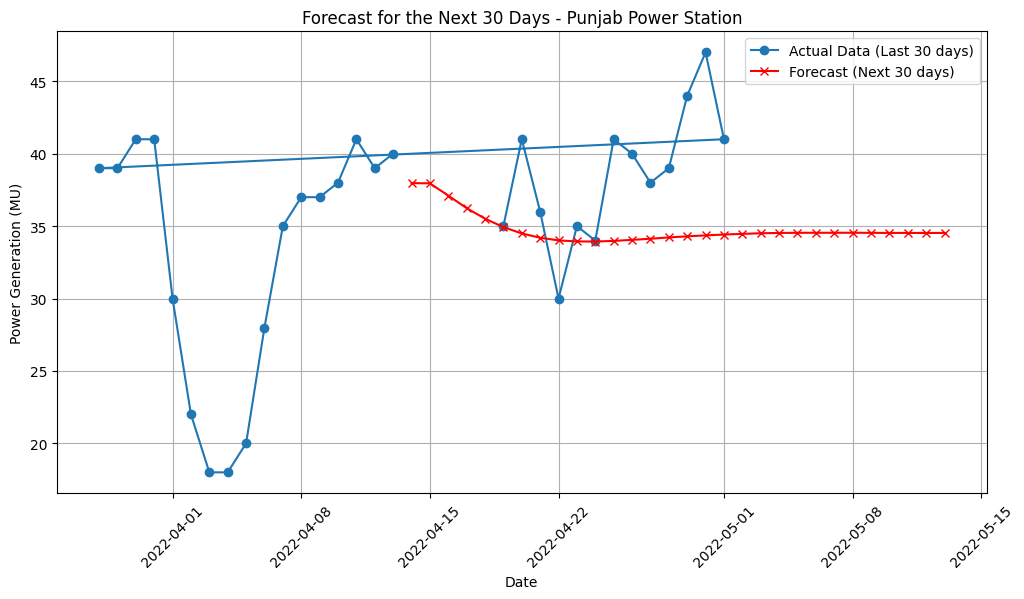

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Inverse transform the actual target data for the last 30 days using `scaler_target`
actual_data_last_30_days = scaler_target.inverse_transform(scaled_data[-30:, -1].reshape(-1, 1))

# Create the date range for the forecast (next 30 days)
forecast_dates = pd.date_range(punjab_data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(punjab_data.index[-30:], actual_data_last_30_days, label='Actual Data (Last 30 days)', marker='o')
plt.plot(forecast_dates, forecast_values, label='Forecast (Next 30 days)', marker='x', color='red')

plt.xlabel('Date')
plt.ylabel('Power Generation (MU)')
plt.title('Forecast for the Next 30 Days - Punjab Power Station')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [ ]:
pip install pycausalimpact

DatetimeIndex(['2017-09-01', '2017-09-02', '2017-09-03', '2017-09-04',
               '2017-09-05', '2017-09-06', '2017-09-07', '2017-09-08',
               '2017-09-09', '2017-09-10',
               ...
               '2022-12-13', '2022-12-14', '2022-12-15', '2022-12-16',
               '2022-12-17', '2022-12-18', '2022-12-19', '2022-12-20',
               '2022-12-21', '2022-12-22'],
              dtype='datetime64[ns]', name='Dates', length=1934, freq=None)
77
            Actual
Date              
2017-11-25    10.0
2018-04-02    13.0
2018-04-02    13.0
2020-03-18     9.0
2020-03-18     9.0
...            ...
2020-03-18     9.0
2020-03-18     9.0
2020-03-18     9.0
2020-03-18     9.0
2020-03-18     9.0

[77 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/causalimpact/main.py:603: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
/usr/local/lib/python3.10/dist-packages/causalimpact/main.py:302: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mu_sig = (mu[0], sig[0])
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, 

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    21.56              13709.56
Prediction (s.d.)         7.72 (2.78)        4910.39 (1765.44)
95% CI                    [2.23, 13.11]      [1415.2, 8335.6]

Absolute effect (s.d.)    13.84 (2.78)       8799.17 (1765.44)
95% CI                    [8.45, 19.33]      [5373.96, 12294.37]

Relative effect (s.d.)    179.2% (35.95%)    179.2% (35.95%)
95% CI                    [109.44%, 250.37%] [109.44%, 250.37%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 21.56. By contrast, in the absence of an
intervention, we would have expected an average response of 7.72.
The 95% interval of this counterfactual prediction is [2.23, 13.11].
Subtracting this predict

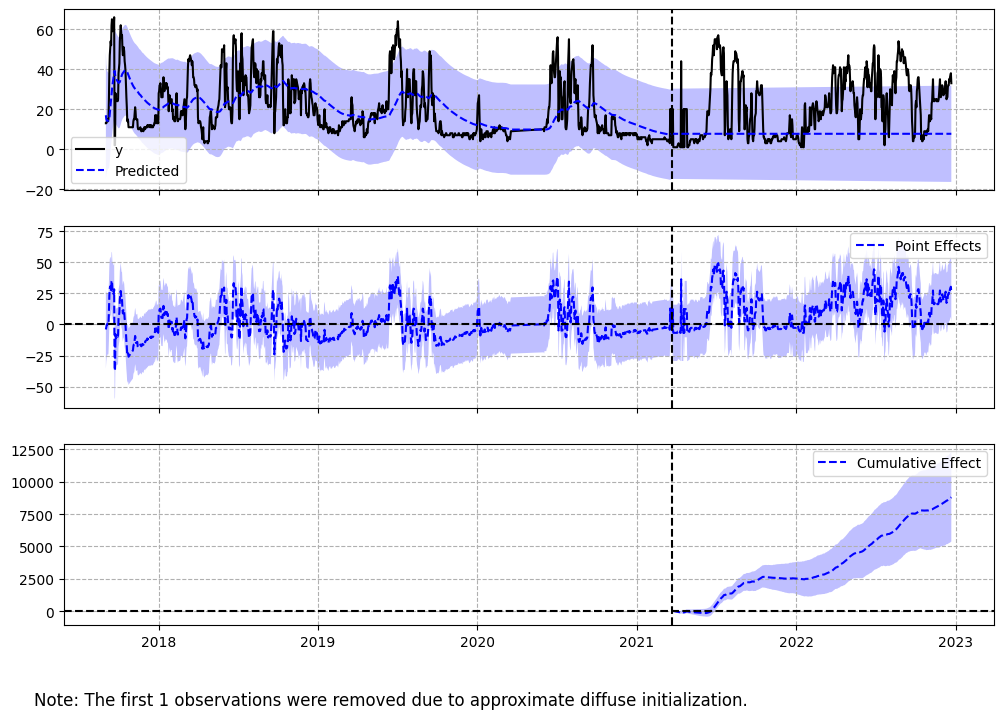

In [ ]:
import pandas as pd
import numpy as np
from causalimpact import CausalImpact
import matplotlib.pyplot as plt

# Define the intervention date (your intervention date: '2021-03-24')
intervention_date = '2021-03-24'

# Create a new DataFrame with the required columns for Causal Impact
ci_data = pd.DataFrame({
    'Date': punjab_data.index,
    'Actual': punjab_data['Actual(MU)'],
})

# Ensure that the data is sorted by the datetime index
ci_data = ci_data.sort_index()

# Check the index to ensure it's a valid DatetimeIndex
print(ci_data.index)

# Set Date as the index
ci_data.set_index('Date', inplace=True)

# Check for duplicate datetime values
print(ci_data.index.duplicated().sum())  # Number of duplicates
print(ci_data[ci_data.index.duplicated()])  # Display duplicate rows

ci_data = ci_data[~ci_data.index.duplicated(keep='first')]  # Keep the first occurrence and remove duplicates


# Define the pre and post-intervention periods
pre_period = [ci_data.index.min(), pd.to_datetime(intervention_date) - pd.Timedelta(days=1)]  # End one day before intervention
post_period = [pd.to_datetime(intervention_date), ci_data.index.max()]  # Start on the intervention date

# Ensure there is a clear split by converting to string type
pre_period = [str(date) for date in pre_period]
post_period = [str(date) for date in post_period]

# Running the Causal Impact analysis
impact = CausalImpact(ci_data['Actual'], pre_period, post_period)

# Print summary of the analysis
print(impact.summary())
print(impact.summary(output='report'))

# Plot the results
impact.plot(figsize=(12, 8))
plt.show()

In [ ]:
pip install shap

Shape of X_test_shap: (381, 240)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Computing SHAP values. This may take a while...


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3650/3650 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step
1/1 

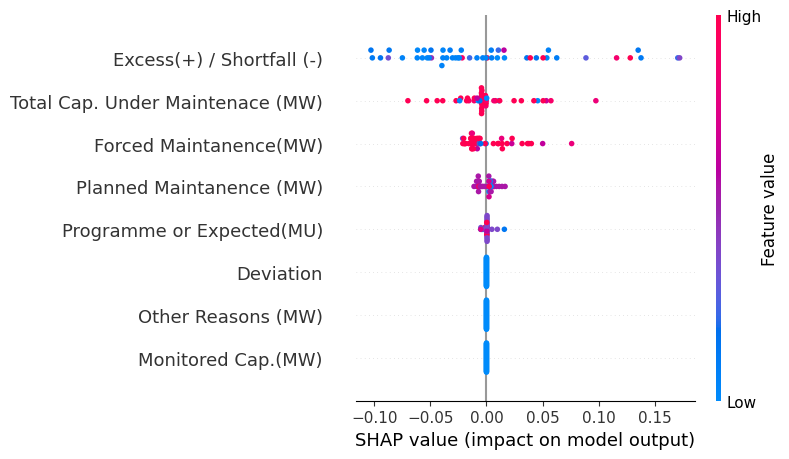

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure you have your LSTM model ready, trained, and `X_test` defined before this step.

# Step 1: Prepare `X_test_shap` for SHAP analysis
# Flatten `X_test` from 3D (samples, time_steps, features) to 2D
n_samples = X_test.shape[0]             # Number of samples in X_test
time_steps = X_test.shape[1]            # Number of time steps (e.g., 30)
n_features = X_test.shape[2]            # Number of features (e.g., 8)

# Flatten the 3D X_test to 2D
X_test_shap = X_test.reshape(n_samples, time_steps * n_features)

# Verify the shape of X_test_shap
print("Shape of X_test_shap:", X_test_shap.shape)  # Expected shape: (n_samples, time_steps * n_features)

# Step 2: Define the wrapper function for LSTM predictions
def lstm_predict_wrapper(X_flattened):
    """
    Wrapper function for the LSTM model to reshape input data and make predictions.
    """
    # Reshape from (n_samples, time_steps * n_features) to (n_samples, time_steps, n_features)
    reshaped_input = X_flattened.reshape(-1, time_steps, n_features)

    # Predict using the trained LSTM model
    predictions_scaled = model.predict(reshaped_input)

    # Inverse transform the predictions to get actual values
    predictions_actual = scaler_target.inverse_transform(predictions_scaled.reshape(-1, 1))
    return predictions_actual.flatten()

# Step 3: Initialize KernelExplainer with the wrapper function
explainer = shap.KernelExplainer(lstm_predict_wrapper, X_test_shap[:50], link="identity")

# Step 4: Compute SHAP values for the first 100 samples
print("Computing SHAP values. This may take a while...")
shap_values = explainer.shap_values(X_test_shap[:50])

# Step 5: Reshape SHAP values from (100, 240) to (100, time_steps, n_features)
shap_values_reshaped = np.array(shap_values).reshape(50, time_steps, n_features)

# Step 6: Aggregate SHAP values across time steps (average impact for each feature)
shap_values_avg = np.mean(shap_values_reshaped, axis=1)

# Step 7: Generate SHAP summary plot for all features
feature_columns = [col for col in punjab_data.columns if col != 'Actual(MU)' and col != 'Dates']
print("Generating SHAP summary plot...")
shap.summary_plot(shap_values_avg, X_test_shap[:50, :n_features], feature_names=feature_columns)
shap.force_plot(explainer.expected_value, shap_values_avg[0], X_test_shap[:1, :n_features], feature_names=feature_columns)